## Epidemiology model for spread of COVID-19
### Author: Dr Wladimir Lyra, New Mexico State University




In this code I will use a SEAIR (susceptible-infected-removed, plus exposed and assymptomatic) model. The model traces the evolution of a susceptible population $S$, exposed $E$, infected $I$, and removed population, $R$. The equations are


\begin{eqnarray}
\frac{dS_i}{dt} &=&-\beta(t) \left[\sum_i\frac{(I_i+A_i)}{N_i}\right]S_i - \psi_i S_i + \phi_i C_i\\
\frac{dC_i}{dt} &=& \psi_i S_i - \phi_i C_i\\
\frac{dE_i}{dt} &=& \beta(t) \left[\sum_i\frac{(I_i+A_i)}{N_i}\right]S_i - \sigma E_i\\
\frac{dA_i}{dt} &=& (1-p)\sigma E_i -\theta A_i\\
\frac{dI_i}{dt} &=& p\sigma E_i - \gamma I_i - \xi_i I_i\\
\frac{dH_i}{dt} &=& \xi_i I_i - \eta H_i \\
\frac{dR_i}{dt} &=& \gamma I_i + \theta A_i + \eta H_i
\end{eqnarray}


The $\psi_i$ quantity defines the lockdown, when a fraction $a_i$ is removed from the susceptible population and placed in the confined compartment, effective removed from the epidemics. The $\phi_i$ quantity defines the release from lockdown, when a fraction $b_i$ is removed from the confined population and placed in the susceptible compartment, back in the epidemics. 

\begin{eqnarray}
\psi_i &=& a_i\delta(t-t_{\rm lockdown})\\
\phi_i &=& b_i\delta(t-t_{\rm release})
\end{eqnarray}

$\beta$ is the infection rate, $\sigma$ is the incubation rate, $\gamma$ is the removal rate of , and $\mu$ is the death rate. The subscript $i$ refer to age bins. The population is split in bins of 1-10,10-20...70-80, and 80+. Each bins has its own hospitalization rate $\xi_i$. We trace also those who need ICU care 

\begin{equation}
U_i = \zeta_i H_i
\end{equation}

where $\zeta_i$ is the fraction of the hospitalized cases that need icu care, again a function of age. 

Contact with infected people removes a fraction of the susceptible population at the rate $\beta I S $, placing them at the infected population. At the same time, the infected population has a recovery rate $\gamma$. 

### The parameter $R_0$

We can gain understanding of the dynamics of the infected population by writing its equation as 

\begin{equation}
\frac{dI}{dt} = \gamma I \left(\frac{\beta}{\gamma} \frac{S}{N} - 1 \right),
\end{equation}

and noticing that in the beggining of the infection, when $S \approx N$ (where $N$ is the size of the population) it reduces to 

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(\frac{\beta}{\gamma}  - 1 \right).
\end{equation}

The dynamics of the infected population is controled by the parameter 

\begin{equation}
R_0 = \frac{\beta}{\gamma}
\end{equation}

When $R_0 > 1$ the infected population grows exponentially. When $R_0 \leq 1$ the disease is controlled. 

$R_0$ can be thought of as the average number of people an infected person will contaminate before being removed. As such, it is called the basic reproduction number. Social distancing has the effect of lowering the infection rate $\beta$, and thus the basic reproduction number $R_0$. 

We adjust $R$ as a function of time according to 


\begin{equation}
R(t) = \left\{\mu_i\gamma \left[A(t)+I(t)\right] S(t) \right\}^{-1} \frac{d}{dt}D(t_r)
\end{equation}



### Doubling time and application to current COVID-19 epidemics

Based on  

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(R_0  - 1 \right)
\end{equation}

we can relate the doubling time of the infection to $R_0$. The e-folding time is 

\begin{equation}
t_e = \frac{1}{\gamma \left(R_0-1\right)}
\end{equation}

So the doubing time is 

\begin{equation}
t_{\rm double} = t_e \ \ln 2 = \frac{\ln 2}{\gamma \left(R_0-1\right)}
\end{equation}


In [1]:
import numpy as np
import pylab as plt
import sys 
#
Tincubation      = 5.2  # length of incubation period
Tinfection       = 2.9  # duration patient is infectious
Thospitalization = 5.   # time to hospitalization
Thospitalized    = 10.  # length of hospital stay

Tdeath           = 14.  # time from exposure to death
#Tdeath           = Tincubation + Tinfection + Thospitalization + Thospitalized

R0=2.8
# fraction of symptomatic and asymptomatic cases
p=0.6
w=0.8 #assymptomatic that cure on their own
# fraction of cases that require hospitalization
# Timescales
sigma = 1./Tincubation
gamma = 1./Tinfection
mu    = 1./Tdeath  
eta   = 1./Thospitalized
xi    = 1./Thospitalization

theta = mu
tmu = Tdeath

# confinement percentage for different populations
#age bins = [0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80+] age bins
fac1=0.0 # fraction removed and confined 
factor1 = np.array([fac1,fac1,fac1,fac1,fac1,fac1,fac1,fac1,fac1])
fac2=0.0 # fraction released from confinment
factor2 = np.array([fac2,fac2,fac2,fac2,fac2,fac2,fac2,fac2,fac2])

a = 1.575  # empirically determined for dirac delta
ampl1 =  factor1*a
ampl2 =  factor2*a


#
# London study breakdown by age
#
age_bins                     = np.array([10,20,30,40,50,60,70,80,90])
fatality_rate_age            = .01*np.array([0.002,0.006,0.03,0.08,0.15,0.60,2.2,5.1,9.3])
hospitalization_fraction_age = .01*np.array([0.1,0.3,1.2,3.2,4.9,10.2,16.6,24.3,27.3])
critical_care_age            = .01*np.array([5,5,5,5,6.3,12.2,27.4,43.2,70.9])
#icu_fraction_age             =  hospitalization_fraction_age*critical_care_age

q = hospitalization_fraction_age
gammap = gamma + (1-q)*xi
    
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes                   
plt.rc('axes', titlesize=MEDIUM_SIZE) # fontsize of the axes title               
plt.rc('axes', labelsize=BIGGER_SIZE) # fontsize of the x and y labels           
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize                         
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title         


The next blocks have funtion definitions

In [2]:
 import datetime 

In [3]:
def date_to_time(d):
    #from datetime import datetime    

    n=len(d)    
    
    date=np.zeros(n)
    for i in range(n):
        date_object = datetime.datetime.strptime(d[i], '%m/%d/%y')
        date[i] = datetime.datetime.fromisoformat(np.str(date_object)).timestamp()
                  
    return (date-date[n-1])/86400.                

#################################################################    
    
def calc_doubling_time(time,cases):

    exponential_slope = np.gradient(np.log(1.0*cases+1e-10),time) 

    n=len(exponential_slope)
    doubling_time=np.zeros(n)
    for i in range(n):
        if (exponential_slope[i] != 0):
            doubling_time[i] = np.log(2.)/exponential_slope[i]
        else:
            doubling_time[i]=0.0
    
    return doubling_time

#################################################################

def get_fatality_rate(age):
    return np.sum(fatality_rate_age*age)/np.sum(age)

#################################################################

def read_jhu_data(country,mode):
    import csv
    #base='./dat/time_series_19-covid-' 
    #with open(base+mode+'.csv', newline='') as csvfile:
    base='./dat/time_series_covid19_' 
    with open(base+mode+'_global.csv', newline='') as csvfile:    
        datareader = csv.reader(csvfile)#, delimiter=',', quotechar='|')
        data = {} 
        for row in datareader:
            if (row[0] == 'Province/State'):
                n=len(row)
                dates = row[4:n]
                for i in range(len(dates)):
                    data[dates[i]]=0
            else:
                if (row[1]==country):
                    for i in range(len(dates)):
                        if (row[i+4]==''): 
                            row[i+4]='0'                        
                        data[dates[i]] += np.int(row[i+4])
    
    return data,dates                
  
#################################################################    

def read_population_pyramid_data(country):
    import csv
    #base='./dat/time_series_19-covid-' 
    #with open(base+mode+'.csv', newline='') as csvfile:
    if (country=='Korea, South'):
        file='./dat/pop/SKorea-2019.csv' 
    elif (country=='United Kingdom'):
        file='./dat/pop/UK-2019.csv' 
    else:
        file='./dat/pop/'+country+'-2019.csv' 
#
    with open(file, newline='') as csvfile:    
        datareader = csv.reader(csvfile)#, delimiter=',', quotechar='|')
        #data = {} 
        population=[]
        for row in datareader:
            if (row[0] != 'Age'):
                population.append(np.int(row[1])+np.int(row[2]))
    
    pop=np.array(population)
    age_brackets=np.zeros(9)
    for i in range(9):
        #print(i,2*i,2*i+1)
        age_brackets[i] = pop[2*i]+pop[2*i+1]
    #add the 90+ to the 80-90    
    age_brackets[8]=age_brackets[8] + np.sum(pop[len(pop)-3:len(pop)-1])
    
    return age_brackets
  
#################################################################    

def appendvalues(S,C,E,A,I,Q,H,U,R,F,D,t,SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt):
    SS.append(S)
    CC.append(C)    
    EE.append(E)
    AA.append(A)    
    II.append(I)
    QQ.append(Q)    
    HH.append(H)
    UU.append(U)    
    RR.append(R)
    FF.append(F)
    DD.append(D)
    tt.append(t)
    return SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt    
    
#################################################################    
    
def get_kronecker_delta(time,t0,tt,ampl,dt):    
    
    if (time-t0 > 0 and tt-t0<0):
        delta=1.
    else:
        delta=0.
    psi=delta*ampl/dt
    
    return psi    
        
#################################################################    
    
def write_data(it,t,dt,Rt,g,d):        
    
    g.write("%d %E %E %E %E %E %E %E %E %E %E %E %E\n"
                %(it,t,dt,Rt,d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8]))    

#################################################################
    
def get_data_country(name):

    #dict_confirmed,dates = read_jhu_data(name,'Confirmed')
    #dict_recovered,dates = read_jhu_data(name,'Recovered')
    #dict_deaths,dates    = read_jhu_data(name,'Deaths')

    dict_confirmed,dates = read_jhu_data(name,'confirmed')
    dict_recovered,dates = read_jhu_data(name,'recovered')
    dict_deaths,dates    = read_jhu_data(name,'deaths')
    
    n1=len(dict_confirmed.keys())
    n2=len(dict_recovered.keys())
    if (n1!=n2):
        sys.exit()
    n3=len(dict_deaths.keys())    
    if (n2!=n3):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    recovered=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        recovered[i] = dict_recovered[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]


    country = dict([
                    ('name',name),
                    ('dates', dates),
                    ('confirmed', confirmed),
                    ('recovered', recovered),
                    ('deaths', deaths),
                   ])        
        
    return country
            

### Death rate 

The last parameter in the model is the death rate. The removed are either recovered/cured (C) or dead (D), according to 

\begin{eqnarray}
D(t) &=& \mu \ I(t-\tau_\gamma)
\end{eqnarray}

where $\mu$ is the death rate. The cured are supposed to have gained immunity and not added again to the susceptible population. Current knowledge of the epidemic seem to imply $\mu$=0.01. 

### Model applied to the current epidemics 

Given a universal $\gamma=0.04$, the model input are the doubling times $t_{\rm double}$ and the initial number of infected $I_0$. Below are the numbers of March 14th for Italy, S. Korea, China, and the USA. The total population is for normalization purposes only. The model assumes N=1 and works with population fractions instead.  




In [4]:
def select_country(name):
    
    import csv
    #import urllib2
    from urllib.request import urlopen
    
    dict_confirmed,dates = read_jhu_data(name,'Confirmed')
    dict_deaths,dates    = read_jhu_data(name,'Deaths')
    
    n1=len(dict_confirmed.keys())
    n2=len(dict_deaths.keys())    
    if (n1!=n2):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]

    D0=1.

    #mortality from 
    #populations from population pyramid
    color='black'
    if (name=="China"):
        lockdown = '1/23/20'
        color='blue'
        D0=min(deaths)
        median_age=38.4
        icu_beds_per_1e5=3.6
    elif (name== "Korea, South"):
        lockdown = '2/18/20'        
        color='orange'
        median_age=40.8
        icu_beds_per_1e5=10.6        
    elif (name == 'Iran'):    
        lockdown = '2/22/20'
        color='green'
        median_age=32.
        icu_beds_per_1e5=5.3        
    elif (name == 'Italy'):
        lockdown = '3/09/20'
        color='red'
        median_age=47.3
        icu_beds_per_1e5=12.5        
    elif (name == 'Denmark'):
        lockdown = '3/11/20'        
        color='purple'
        median_age=41.6
        icu_beds_per_1e5=6.7        
    elif (name == 'Norway'):
        lockdown = '3/12/20'                       
        color='brown'
        median_age=39.2
        icu_beds_per_1e5=8.        
    elif (name == 'Poland'):
        lockdown = '3/13/20'                               
        color='pink'
        median_age=39.7
        icu_beds_per_1e5=6.9        
    elif (name=="Spain"):
        lockdown = '3/14/20'
        color='grey'   
        median_age=43.1
        icu_beds_per_1e5=9.7        
    elif (name=="US"):
        lockdown = '3/19/20'
        color='magenta'
        median_age=38.2
        icu_beds_per_1e5=34.7        
    elif (name=="Sweden"):
        lockdown = ''
        median_age=40.9
        icu_beds_per_1e5=5.8        
    elif (name=="Brazil"):
        lockdown='3/24/20'
        color='cyan'
        median_age=31.4
        icu_beds_per_1e5=18.        
    elif (name=="Tunisia"):
        lockdown ='3/22/20'
        color='black' 
        median_age=31.3
        icu_beds_per_1e5=2.72        
    elif (name=="Germany"):
        lockdown = ''  
        median_age=45.9
        icu_beds_per_1e5=29.2        
    elif (name=="Japan"):
        lockdown = '' 
        median_age=47.3
        icu_beds_per_1e5=7.3        
    elif (name=="France"):
        lockdown = ''  
        median_age=41.2
        icu_beds_per_1e5=11.6        
    elif (name=='Ireland'):
        lockdown = ''  
        median_age=36.5
        icu_beds_per_1e5=6.5        
    elif (name=='Uruguay'):   
        lockdown= ''
        median_age=34.9
        icu_beds_per_1e5=6.        
    elif (name=='Chile'):
        lockdown= ''
        median_age=33.8   
        icu_beds_per_1e5=6.        
    elif (name=='India'):
        lockdown= ''
        median_age=26.8
        icu_beds_per_1e5=5.2        
    elif (name=='United Kingdom'):
        lockdown= ''
        median_age=26.8
        icu_beds_per_1e5=6.6        
    elif (name=='Switzerland'):
        lockdown= ''
        median_age=26.8
        icu_beds_per_1e5=11.        
    else:
        print("choose a valid country")
        sys.exit()

    age=read_population_pyramid_data(name)    
    N=np.sum(age)
    fatality_rate            = np.sum(fatality_rate_age           *age)/np.sum(age)
    #hospitalization_fraction = np.sum(hospitalization_fraction_age*age)/np.sum(age)
    #icu_fraction             = np.sum(icu_fraction_age            *age)/np.sum(age)
    number_of_icu_beds=icu_beds_per_1e5 * N / 1e5  

    
    # pick the day of the first death to start the integration; it is the best predictor of what
    # is actually happening in a country;
    if (deaths.max() >= D0):  
        index_D0 = [i for i in range(len(deaths)) if deaths[i] >= D0][0]
    else:
        index_D0 = 0
    date_D0 = dates[index_D0]
    
    days_past=date_to_time(dates)    
    time_D0=days_past[index_D0]
    doubling_time=calc_doubling_time(days_past,confirmed)[len(days_past)-1]    

    country = dict([
                    ('name', name),
                    ('D0',D0),
                    ('N',N),
                    ('days past',days_past),
                    ('cases',confirmed),
                    ('doubling time',doubling_time),
                    ('deaths',deaths),
                    ('time_D0',time_D0),
                    ('index_D0',index_D0),
                    ('lockdown',lockdown),
                    ('color',color),
                    ('fatality_rate',fatality_rate),
                    ('median_age',median_age),
                    #('hospitalization_fraction',hospitalization_fraction),
                    #('icu_fraction',icu_fraction),
                    ('number_of_icu_beds',number_of_icu_beds),
                    ('age',age)
                   ])

    #print("Parameters for:",country['name'])
    #print("Doubling time =",doubling_time," days")
    #print("Fatality rate =",100*fatality_rate," %")
    
    return country


In [5]:
def RK3(f):
    N             = f['N']
    D0            = f['D0']
    time_D0       = f['time_D0']
    iD0           = f['index_D0']
    days_past     = f['days past']
    deaths        = f['deaths']    
    name          = f['name']
    lockdown      = f['lockdown']
    fatality_rate = f['fatality_rate']
    #hosp_fraction = f['hospitalization_fraction']
    #icu_fraction  = f['icu_fraction']
    number_of_icu_beds=f['number_of_icu_beds']
    pop               =f['age']
    
    alpha_ts   = np.double([0.   , -5./9.  ,-153./128.])
    beta_ts    = np.double([1./3., 15./16. ,   8./15. ])
    Cdt = 0.5

    #
    # Deaths reflect infections 1/gamma days past
    #
    I0    = (D0/N)/fatality_rate
    nu    = fatality_rate_age
#    
    cases=np.array(deaths[iD0:len(deaths)])
    tpast=days_past[iD0:len(deaths)]
    dDdt = np.gradient((1.0*cases/N),tpast)  
    beta = R0*gamma
#
#  Timestep defined by the timescale given by the rate of infection 
#
    tau_beta  = 1/beta #np.min(1./pastbeta)
    dt = Cdt*tau_beta
#    
# End of epidemics. 
#
    tmax = 20*tmu
#
# Lists to store the populations 
#
    SS=[]  # susceptible
    CC=[]  # confined
    EE=[]  # exposed
    AA=[]  # assymptomatic    
    II=[]  # infected symptomatic
    QQ=[]  # isolated
    HH=[]  # hospitalized 
    UU=[]  # ICU patients    
    RR=[]  # removed
    FF=[]  # dead (fatalities)
    DD=[]  # dead -- different array for comparison
    tt=[]  # time
#
    #SS2=[]
    #EE2=[]
    #AA2=[]    
    #II2=[]
    #RR2=[]
#
# Initial values 1/gamma ago  
#
    I=np.zeros(9)
    I[4]=I0
    C=np.zeros(9)
    E=np.zeros(9)
    A=np.zeros(9)
    Q=np.zeros(9)
    H=np.zeros(9)
    R=np.zeros(9)
    F=np.zeros(9)    
    ni=pop/N
    S=(1-C-E-A-I-Q-H-R-F) * ni
    U=np.zeros(9)
    D=np.zeros(9)
    
#    
    sS=sum(S)
    #sC=sum(C)
    sE=sum(E)
    sA=sum(A)
    sI=sum(I)
    #sH=sum(H)
    #sR=sum(R)   
#
    dSdt=np.zeros(9)
    dCdt=np.zeros(9)
    dEdt=np.zeros(9)
    dAdt=np.zeros(9)
    dIdt=np.zeros(9)
    dQdt=np.zeros(9)    
    dHdt=np.zeros(9)
    dRdt=np.zeros(9)
    dFdt=np.zeros(9)    

    #I2=I
    #E2=E
    #A2=A    
    #R2=R
    #S2=S
    
#  Start the integration
    itmax=100000   
#
#  Use t=0 as the time of first death minus 1/gamma
#
    t= time_D0-tmu
    ds=0.
#
    SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt = appendvalues(sS,0.,0.,sA,sI,0.,0.,0.,0.,0.,0.,t,SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt)
    RRt=[R0]

    #SS2.append(S2)
    #EE2.append(E2)
    #AA2.append(A2)    
    #II2.append(I2)
    #RR2.append(R2)

    if (lockdown!=''):
        lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        today         = datetime.datetime.today()
        date1         = datetime.datetime.fromisoformat(np.str(lockdown_date)).timestamp()
        date2         = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
        tlockdown     = (date1-date2)/86400.
    else:
        tlockdown=0.

    release='4/05/20'    
    release_date      = datetime.datetime.strptime(release, '%m/%d/%y')
    today             = datetime.datetime.today()
    date1             = datetime.datetime.fromisoformat(np.str(release_date)).timestamp()
    date2             = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
    trelease          = (date1-date2)/86400.
    
#
#  Open file for writing
#
    fS = open('data/'+name+'_Sfile.dat','w+')
    fC = open('data/'+name+'_Cfile.dat','w+')
    fE = open('data/'+name+'_Efile.dat','w+')
    fA = open('data/'+name+'_Afile.dat','w+')
    fI = open('data/'+name+'_Ifile.dat','w+')
    fQ = open('data/'+name+'_Qfile.dat','w+')
    fH = open('data/'+name+'_Hfile.dat','w+')
    fU = open('data/'+name+'_Ufile.dat','w+')
    fR = open('data/'+name+'_Rfile.dat','w+')    
        
    #print 'it --- t (day) --- dt --- Rt --- S'
    #f.write("%d %E %E %E %E %E %E %E %E %E %E %E %E\n"%(it,t,dt,Rt,S[0:9]))
    
    for it in np.arange(itmax):
#                                                                                
        psi1=get_kronecker_delta(t,tlockdown,np.array(tt)[it-1],ampl1,dt)
        psi2=get_kronecker_delta(t,trelease ,np.array(tt)[it-1],ampl2,dt)        
#               
        dt_beta_ts = [i * dt for i in beta_ts]
#                                                                                
        tretarded = t + tmu
        if (tretarded < 0):    
            #beta = np.interp(tretarded,tpast,pastbeta)
            dDdt_ = np.interp(tretarded,tpast,dDdt)               
            smuS = sum(fatality_rate_age*S)
            #smuS = fatality_rate*sS
            beta = 1/smuS * 1/(sA+sI) * dDdt_ 
            beta = 1/(sA+sI) * 1/sS * 1/(fatality_rate) * np.interp(tretarded,tpast,dDdt)  
            Rt = beta/gamma                      
        else:
            if (name=='Tunisia'):
                # still low statistics
                Rt = np.mean(RRt[it-10:it])
                beta = Rt*gamma                    
            else:
                beta = beta
#
# advance time
#
        for itsub in range(3):
            ds  = alpha_ts[itsub]*ds
            ds  = ds+1.
            t   = t + dt_beta_ts[itsub]*ds
#
# advance quantities
#
        for itsub in range(3):
            sI=sum(I)
            sA=sum(A)
            Finf=beta*(sI+sA)
            for ip in range(9): #subpopulation bins 
                dSdt[ip]   = alpha_ts[itsub]*dSdt[ip]
                dCdt[ip]   = alpha_ts[itsub]*dCdt[ip]            
                dEdt[ip]   = alpha_ts[itsub]*dEdt[ip]
                dAdt[ip]   = alpha_ts[itsub]*dAdt[ip]            
                dIdt[ip]   = alpha_ts[itsub]*dIdt[ip]
                dQdt[ip]   = alpha_ts[itsub]*dQdt[ip]                
                dHdt[ip]   = alpha_ts[itsub]*dHdt[ip]            
                dRdt[ip]   = alpha_ts[itsub]*dRdt[ip]
                dFdt[ip]   = alpha_ts[itsub]*dFdt[ip]                
                        
            #dSdt = dSdt - beta*(I+A)*S - psi*S  + phi*C
            #dCdt = dCdt                + psi*S  - phi*C
            #dEdt = dEdt + beta*(I+A)*S         -       sigma*E            
            #dAdt = dAdt                        + (1-p)*sigma*E - theta*A
            #dIdt = dIdt                        +    p *sigma*E            -   gamma*I
            #dQdt = dQdt                                                       gamma*I -       xi*Q            
            #dHdt = dHdt                                                               +    q *xi*Q - eta*H
            #dRdt = dRdt                                         + theta*A             + (1-q)*xi*Q + eta*H

                dSdt[ip] = dSdt[ip] - Finf*S[ip] - psi1[ip]*S[ip] + psi2[ip]*C[ip]
                dCdt[ip] = dCdt[ip]              + psi1[ip]*S[ip] - psi2[ip]*C[ip] 
                dEdt[ip] = dEdt[ip] + Finf*S[ip]                             -       sigma*E[ip]            
                dAdt[ip] = dAdt[ip]                                          + (1-p)*sigma*E[ip] -       theta*A[ip]
                dIdt[ip] = dIdt[ip]                                          +    p *sigma*E[ip] + (1-w)*theta*A[ip] - gamma*I[ip] -           xi*I[ip]    

                #dQdt[ip] = dQdt[ip]                                                                                  + gamma*I[ip] -           xi*Q[ip]
                
                dHdt[ip] = dHdt[ip]                                                                                                +    q[ip] *xi*I[ip] -            eta*H[ip]
                dRdt[ip] = dRdt[ip]                                                              +    w *theta*A[ip] + gamma*I[ip] + (1-q[ip])*xi*I[ip] + (1-nu[ip])*eta*H[ip]
                dFdt[ip] = dFdt[ip]                                                                                                                     +    nu[ip] *eta*H[ip]

                S[ip] = S[ip] + dt_beta_ts[itsub]*dSdt[ip]
                C[ip] = C[ip] + dt_beta_ts[itsub]*dCdt[ip]            
                E[ip] = E[ip] + dt_beta_ts[itsub]*dEdt[ip]
                A[ip] = A[ip] + dt_beta_ts[itsub]*dAdt[ip]            
                I[ip] = I[ip] + dt_beta_ts[itsub]*dIdt[ip]
                Q[ip] = Q[ip] + dt_beta_ts[itsub]*dQdt[ip]                
                H[ip] = H[ip] + dt_beta_ts[itsub]*dHdt[ip]            
                R[ip] = R[ip] + dt_beta_ts[itsub]*dRdt[ip]
                F[ip] = F[ip] + dt_beta_ts[itsub]*dFdt[ip]

                U[ip] = H[ip]*critical_care_age[ip]
                D[ip] = fatality_rate_age[ip]*(ni[ip]-(S[ip]+C[ip]))
                #D[ip] = fatality_rate_age[ip]*E[ip]
                
        #print(it,t,sum(S),sum(C),sum(E),sum(A),sum(I),sum(H),sum(R),sum(D))                                
                
        SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt = appendvalues(sum(S),sum(C),sum(E),sum(A),sum(I),sum(Q),sum(H),sum(U),sum(R),sum(F),sum(D),
                                                                        t,
                                                                        SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt)
        RRt.append(Rt)
# 
        write_data(it,t,dt,Rt,fS,S)
        write_data(it,t,dt,Rt,fC,C)
        write_data(it,t,dt,Rt,fE,E)
        write_data(it,t,dt,Rt,fA,A)
        write_data(it,t,dt,Rt,fI,I)
        write_data(it,t,dt,Rt,fQ,Q)
        write_data(it,t,dt,Rt,fH,H)        
        write_data(it,t,dt,Rt,fU,U)
        write_data(it,t,dt,Rt,fR,R)        
        
        ##lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ##today         = datetime.datetime.today()
        #date1 = datetime.datetime.fromisoformat(np.str(datetime.datetime.strptime(lockdown, '%m/%d/%y'))).timestamp()
        #date2 = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
        #tlockdown=(date1-date2)/86400.
        #if (t < tlockdown):    
        #    beta2=beta
        #    itlockdown=it
        #else:
        #    Rt2 = np.median(np.array(RRt[0:itlockdown])) 
        #    beta2 = Rt2*gamma            
        #for itsub in np.arange(0,3):
        #    dSdt   = alpha_ts[itsub]*dSdt
        #    dEdt   = alpha_ts[itsub]*dEdt            
        #    dIdt   = alpha_ts[itsub]*dIdt
        #    dRdt   = alpha_ts[itsub]*dRdt
        #    dSdt = dSdt - beta2*I2*S2
        #    dEdt = dEdt + beta2*I2*S2 - sigma*E2            
        #    dIdt = dIdt               + sigma*E2 - gamma*I2   
        #    dRdt = dRdt                          + gamma*I2
        #    S2 = S2 + dt_beta_ts[itsub]*dSdt
        #    E2 = E2 + dt_beta_ts[itsub]*dEdt            
        #    I2 = I2 + dt_beta_ts[itsub]*dIdt
        #    R2 = R2 + dt_beta_ts[itsub]*dRdt     
        #SS2.append(S2)
        #EE2.append(E2)
        #II2.append(I2)
        #RR2.append(R2)        
#
        if ((it == itmax) or t > tmax):
            print(f'End of simulation at t = {np.int(t):d} days \n')
            #
            #  Separate the removed into recovered and dead according to death rate
            #
        
            #print('Percentage of people who avoided infection, S=',np.int(np.round(100*S)),'%')       
            #print('Percentage of exposed, E=',np.int(np.round(100*E)),'%')       
            #print('Percentage of infectious, I=',np.int(np.round(100*I)),'%')    
            #print('Percentage of removed, R=',np.int(np.round(100*R)),'%\n')
            print(name)
            print('Percentage infected at peak of epidemics: ',   np.int(np.round(100*np.array(II+AA).max())),'%')
            print('Number Symptomatic at peak of epidemics: '   ,np.int(np.round(N*np.array(II).max()))) 
            print('Number Asymptomatic at peak of epidemics: '   ,np.int(np.round(N*np.array(AA).max()))) 
            print('Number of hospitalized at peak of epidemics: ',np.int(np.round(N*np.array(HH).max())))            
            print('Number needing ICU at peak of epidemics: ',    np.int(np.round(N*np.array(UU).max())))
            #print('Total number of deaths' = {np.int(np.round(D*N)):d})
            #print(f'Total number of deaths averted = {np.int(np.round((D2-D)*N)):d}')

            break
            
    results = dict([('Susceptible', SS),
                    ('Confined', CC),
                    ('Exposed', EE),
                    ('Asymptomatic',AA),
                    ('Infectious', II), 
                    ('Quarantined', QQ),                                        
                    ('Hospitalized', HH),
                    ('ICU', UU),                    
                    ('Removed', RR),
                    ('Fatalities', FF),                    
                    ('Dead',DD),
                    ('RRt',RRt),
                    #('S2', SS2),('E2', EE2),('I2', II2), ('R2', RR2),                    
                    ('Time',tt)])

    fS.close()
    fC.close()
    fE.close() 
    fA.close()
    fI.close()    
    fQ.close()
    fH.close()
    fU.close()
    fR.close() 
    
    return results

In [6]:
 def plottage(country,results):

    import matplotlib.dates as mdates
    
    t=np.array(results['Time'])    
    S=np.array(results['Susceptible'])
    C=np.array(results['Confined'])    
    E=np.array(results['Exposed'])
    A=np.array(results['Asymptomatic'])    
    I=np.array(results['Infectious'])
    Q=np.array(results['Quarantined'])    
    H=np.array(results['Hospitalized'])
    U=np.array(results['ICU'])    
    R=np.array(results['Removed'])
    F=np.array(results['Fatalities'])    
    Dm=np.array(results['Dead'])
#   
    N             = country['N']
    deaths        = country['deaths']
    days_past     = country['days past']
    D0            = country['D0']
    name          = country['name']
    lockdown      = country['lockdown']
    fatality_rate = country['fatality_rate']    
    #icu_fraction  = country['icu_fraction']
    number_of_icu_beds=country['number_of_icu_beds']
#
    strS    = 'Susceptible'
    strC    = 'Confined'    
    strE    = 'Exposed'    
    strA    = 'Asymptomatic'    
    strI    = 'Infectious'
    strR    = 'Removed'
    strQ    = 'Quarantined'    
    strH    = 'Hospitalized'    
    strD    = 'Dead'
    strII   = 'Infections'
    strDD   = 'Deaths'
    strdt   = 'Doubling Time'
    strdays = 'days'
    strDays = 'Days'
    strPop  = '# of Population'
    strCCas  = '# of Cases'
    strCas  = 'Cummulative # of Cases'

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=[15,25],sharex=True)
    
    #fig, (ax1,ax2) = plt.subplots(2,1,figsize=[15,15],sharex=True)

# Evolution of the populations

    n=len(S)
    
    datelist=[]
    for i in range(n):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[i]))      
    date64=np.array(datelist, dtype='datetime64')         
    date=date64.astype('O')
    #    
    #ax1.plot(date,S,color='green'  ,label=strS)
    #ax1.plot(date,C,color='grey'   ,label=strC)    
    ax1.plot(date,N*E,color='magenta',label=strE)
    ax1.plot(date,N*A,color='purple' ,label=strA)    
    ax1.plot(date,N*I,color='orange' ,label=strI)
    ax1.plot(date,N*Q,color='grey'   ,label=strQ)    
    ax1.plot(date,N*H,color='cyan'   ,label=strH)
    
    ax2.plot(date,N*H,color='cyan'   ,label=strH)    
    ax2.plot(date,N*U,color='magenta',label='ICU Cases')     
    ax2.axhline(number_of_icu_beds,linestyle='--',color='magenta',label='ICU Capacity')    
    
    #ax2.plot(date,N*D,color='black'  ,label=strD)
    ax2.set_yscale("log")
    ax2.set_ylim([1,1.5*N*H.max()])
    
    #ax1.plot(date,100*R,color='blue'   ,label=strR)
    
    #ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
# Cumulative number of infections and deaths 
    cumm_cases=1-(S+C)  # E+A+I+H+R
    ax3.plot(date,N*cumm_cases,color='orange',label="# of Cases (Model)")
    tretarted = t + tmu
    
    D = fatality_rate*np.interp(t,tretarted,cumm_cases)
    print("Number of dead:",np.round(N*D[n-1]))
    itD0     = [i for i in range(n) if D[i] >= (D0+1)/N][0] 
    ax3.plot(date[itD0-1:n-1],N*D[itD0-1:n-1],color='black',label="Deaths (Model)")

    #integratedD = np.zeros(n)
    #dt=np.gradient(t)
    #for i in range(n):
    #    sumD=0.
    #    for j in np.arange(1,i):
    #        sumD = sumD + .5*(Dm[j-1]+Dm[j])*dt[j]
    #    #integratedD[i]=np.sum(.5*(Dm[0:i-1]+Dm[1:i])*dt[1:i]) * 1/(t[i]-t[0])
    #    integratedD[i]=sumD/(t[i]-t[0])
    #ax3.plot(date,N*np.interp(t,tretarted,integratedD),color='black')
    print("Number of dead:",np.round(N*Dm[n-1]))
    
    pastdatelist=[]
    for i in range(len(days_past)):
        pastdatelist.append(datetime.datetime.today() + datetime.timedelta(days=days_past[i]))
    pastdate64=np.array(pastdatelist, dtype='datetime64')         
    pastdate=pastdate64.astype('O')    
    ax3.plot(pastdate,country['cases'],'o',color='orange',label='Confirmed Cases')
    ax3.plot(pastdate,country['deaths'],'o',color='black',label='Deaths')
    
    integratedH = np.zeros(n)
    dt=np.gradient(t)
    for i in range(n):
        sumH=0.
        for j in np.arange(1,i):
            sumH = sumH + .5*(H[j-1]+H[j])*dt[j]
        #integratedD[i]=np.sum(.5*(Dm[0:i-1]+Dm[1:i])*dt[1:i]) * 1/(t[i]-t[0])
        integratedH[i]=sumH#/(t[i]-t[0])
    ax3.plot(date,N*integratedH,color='cyan')    
#    
#    ax3.plot(date,N*F,color='black',linestyle=':')

    ax3.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#
    #S2=np.array(results['S2'])
    #E2=np.array(results['E2'])    
    #I2=np.array(results['I2'])
    #R2=np.array(results['R2'])
    #ax1.plot(date,100*S2,color='green'  ,linestyle=':')
    #ax1.plot(date,100*E2,color='magenta',linestyle=':')    
    #ax1.plot(date,100*I2,color='orange' ,linestyle=':')
    #ax1.plot(date,100*R2,color='blue'   ,linestyle=':')
    #cumm2_cases=E2+I2+R2    
    #D2= np.zeros(n)
    #tretarted = t + tmu
    #cumm2_cases_prior = np.interp(t,tretarted,cumm2_cases)
    #D2 = fatality_rate*cumm2_cases_prior    
    #print("Number of dead - no intervention:",np.round(N*D2[n-1]))   
    #print("Number of dead averted:",np.round(N*(D2[n-1]-D[n-1])))   
    #ax2.plot(date,N*(E2+I2+R2+D2),color='orange',label="# of Cases (Model without Intervention)",linestyle=":")
    #ax2.plot(date[itD0-1:n-1],N*D2[itD0-1:n-1],color='black',label="Deaths (Model without Intervention)",linestyle=":")    
    
# Annotations and prettifying 

    ax1.set_ylabel(strPop)
    ax1.legend(loc="best",fancybox=True,shadow=True)
    title=name+" Populations"
    
    ax1.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax1.annotate('Today', xy=(datetime.datetime.today(), 80),rotation=-90,color='black')
    
    ax1.set_title(title)
    ax1.grid()

    ax2.set_ylabel(strCCas)
    ax2.legend(loc="best",fancybox=True,shadow=True)
    title=name+" Hospitalizations"
    
    ax2.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax1.annotate('Today', xy=(datetime.datetime.today(), 80),rotation=-90,color='black')
    
    ax2.set_title(title)
    ax2.grid()

    
    ax3.set_yscale("log")
    ax3.set_ylim([1,1.5*N])
    
    #ax2.set_xlim(['2020-03-10','2020-03-30'])
    ax3.set_ylabel(strCas)
    title=name+" Cumulative"#+", $N$="+strlog+", $I_{tot}$="+np.str(np.int(I0))
    ax3.set_title(title)

    #ax2.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax2.annotate('Today', xy=(datetime.datetime.today(), 1e5),rotation=-90,color='black')
        
    ax3.legend(loc="best",fancybox=True,shadow=True)
    ax3.grid()
    
    if (lockdown!=''):
        date_object = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ax3.axvline(date_object,linestyle=':',color='red')
        ax3.annotate('Lockdown', xy=(date_object, 5e1),rotation=-90,color='red')

        ax3.axvline(date_object+datetime.timedelta(days=+Tdeath),linestyle='--',color='red')
        ax3.annotate(np.str(np.int(np.round(Tdeath)))+'days after\nlockdown', 
            xy=(date_object+datetime.timedelta(days=+Tdeath), 5e1),
            rotation=-90,
            color='red')    
 

    startdate=date[0]
    ##enddate   = datetime.datetime.strptime('5/01/20', '%m/%d/%y')
    #if (name=="China" or name=="Denmark"):
    #    endd='5/01/20'
    ##elif (name=="Italy"):
    #else:    
    #    endd='6/15/20'
    #
    endd='7/01/20'
    
    enddate   = datetime.datetime.strptime(endd, '%m/%d/%y')
    ax1.set_xlim([startdate,enddate])
    ax2.set_xlim([startdate,enddate])
    ax3.set_xlim([startdate,enddate])    

    #fig.autofmt_xdate()
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig("./figs/"+name+"_"+np.str(datetime.date.today())+".png")

    return 

### Integration

We now solve the system of differential equations with a Runge-Kutta algorithm. The timescales of the model are the infection time, given by the inverse of the infection rate 

\begin{equation}
\tau_\beta = \frac{1}{\beta}
\end{equation}

and the inverse of the recovery rate, which is the timescale of the duration of the epidemics.  

\begin{equation}
\tau_\gamma = \frac{1}{\gamma}
\end{equation}

We take timesteps of half a $\tau_\beta$, and model up to 100 days for fast doubling times ($<10$ days), and 18 months (540 days) for longer, which is the estimated time to develop a vaccine. The universal parameters are: 

#### Running the model

The block below runs the models, per country.

End of simulation at t = 280 days 

China
Percentage infected at peak of epidemics:  0 %
Number Symptomatic at peak of epidemics:  18011
Number Asymptomatic at peak of epidemics:  60646
Number of hospitalized at peak of epidemics:  1814
Number needing ICU at peak of epidemics:  452
End of simulation at t = 280 days 

Korea, South
Percentage infected at peak of epidemics:  4 %
Number Symptomatic at peak of epidemics:  486007
Number Asymptomatic at peak of epidemics:  2070688
Number of hospitalized at peak of epidemics:  71916
Number needing ICU at peak of epidemics:  20592
End of simulation at t = 280 days 

Iran
Percentage infected at peak of epidemics:  1 %
Number Symptomatic at peak of epidemics:  249541
Number Asymptomatic at peak of epidemics:  1104543
Number of hospitalized at peak of epidemics:  22348
Number needing ICU at peak of epidemics:  4869
End of simulation at t = 280 days 

Italy
Percentage infected at peak of epidemics:  5 %
Number Symptomatic at peak of epidemics:  732

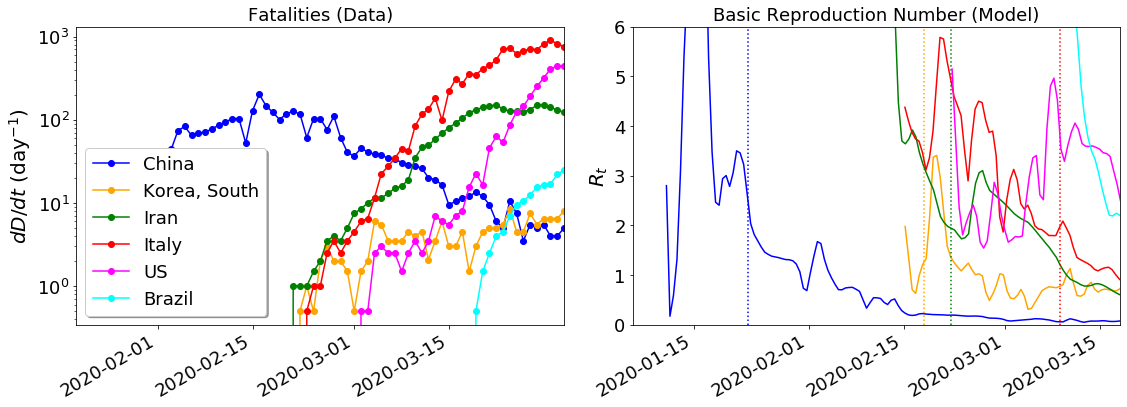

In [7]:
import matplotlib.dates as mdates

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[16,6])

#fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[16,6])

#country_list=['China','Korea, South','Iran','Italy','Denmark','Norway','Poland','Spain','US','Brazil']
country_list=['China','Korea, South','Iran','Italy','US','Brazil']

for i in range(len(country_list)): 
    country = select_country(country_list[i])
    N=country['N']
    lockdown=country['lockdown']
    f=RK3(country)
    t=np.array(f['Time'])  
    color=country['color']
    median_age=country['median_age']
    fatality_rate=country['fatality_rate']    
    
    deaths    = country['deaths']
    tdeaths   = country['days past']
    #lockdown  = country['lockdown']
    #print(country_list[i],deaths)
    iD0 = [i for i in range(len(deaths)) if deaths[i] > 10][0]    
    time_D0=tdeaths[iD0] # tretare
    
    Rt=np.array(f['RRt'])   
    #print(country_list[i],Rt)
        
    t                = np.array(f['Time'])
    n=len(t)
    tretarded        = t + tmu
    itD0 = [i for i in range(n) if tretarded[i] >= time_D0][0]

    datelist=[]
    for k in range(len(t)):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[k]))        
    date64=np.array(datelist, dtype='datetime64')         
    date=date64.astype('O')    
    datelist=[]
    for k in range(len(tdeaths)):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=tdeaths[k]))        
    date64=np.array(datelist, dtype='datetime64')         
    datedeaths=date64.astype('O')    
    
    #ax1.plot(tdeaths,np.gradient(deaths,tdeaths),'-o',label=country_list[i])    
    ax1.plot(datedeaths,np.gradient(deaths,tdeaths),'-o',label=country_list[i],color=color)        
    #ax2.plot(t[itD0:n-1],Rt[itD0:n-1],label=country_list[i])
    ax2.plot(date[itD0:n-1],Rt[itD0:n-1],label=country_list[i],color=color)    
    lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
    ax2.axvline(lockdown_date,linestyle=':',color=color)    

    #ax3.plot(median_age,fatality_rate,'o',color=color)
    
#plt.legend()    
#ax1.fmt_xdata = mdates.DateFormatter('%m/%d/%y')
#ax2.fmt_xdata = mdates.DateFormatter('%m/%d/%y')

ax2.set_ylim([0,6])
#ax2.set_xlim([-70,-Tdeath])

ax1.set_yscale("log")
ax1.legend(loc='best',fancybox='True',shadow='True')
#ax2.legend(loc='best',fancybox='True',shadow='True')

ax1.set_title('Fatalities (Data)')
ax1.set_ylabel(r'$dD/dt$ (day$^{-1}$)')

ax2.set_title('Basic Reproduction Number (Model)')
ax2.set_ylabel(r'$R_t$')

startdate = datetime.datetime.strptime('1/20/20', '%m/%d/%y')
today     = datetime.datetime.today()
ax1.set_xlim([startdate                                ,today                                ])
ax2.set_xlim([startdate-datetime.timedelta(days=Tdeath),today-datetime.timedelta(days=Tdeath)])
#ax2.set_xlim([datetime.datetime.strptime('2/14/20', '%m/%d/%y'),today-datetime.timedelta(days=Tdeath)])

plt.xticks(rotation=45)
fig.autofmt_xdate()

#ax3.set_xlim([20,50])
#ax3.set_ylim([1e-4,3e-2])

plt.tight_layout()

#
#fig.autofmt_xdate()
#
#plt.show()
#
plt.savefig("Rt_data_model.pdf")
#

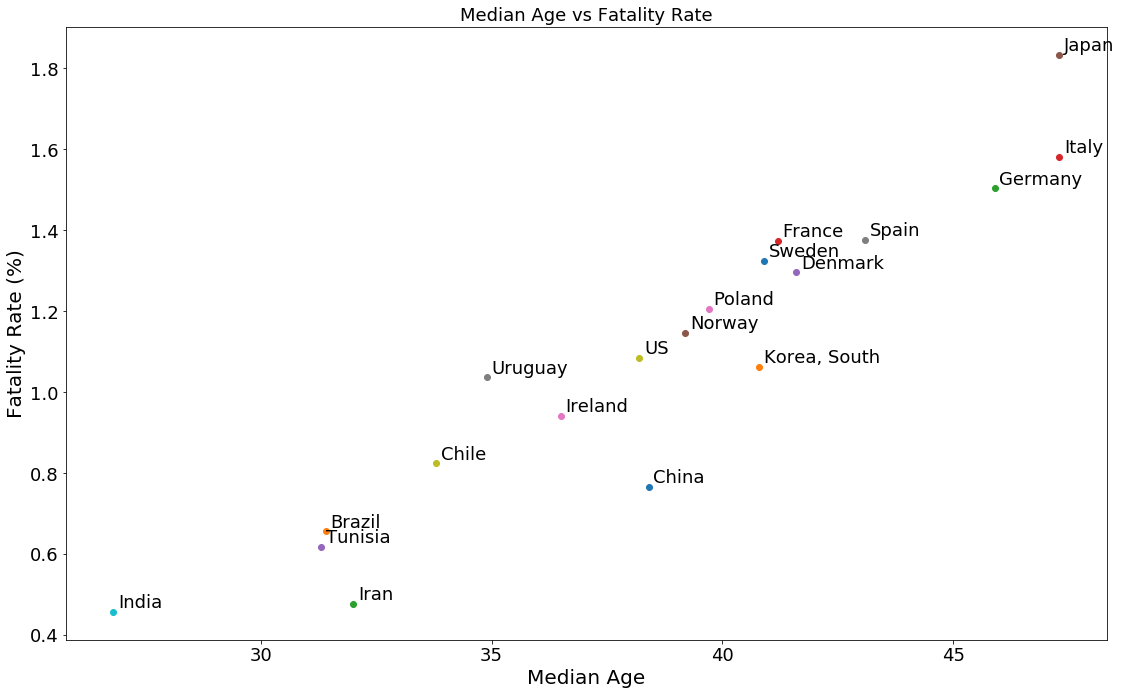

In [8]:
import matplotlib.dates as mdates

fig, (ax1) = plt.subplots(1,1,figsize=[16,10])

country_list=['China','Korea, South','Iran','Italy','Denmark','Norway','Poland','Spain','US','India',
              'Sweden','Brazil','Germany','France','Tunisia','Japan','Ireland','Uruguay','Chile']
for i in range(len(country_list)): 
    country = select_country(country_list[i])
    median_age=country['median_age']
    fatality_rate=country['fatality_rate']    
    
    ax1.plot(median_age,100*fatality_rate,'o')
    ax1.annotate(country_list[i],xy=(median_age+0.1,100*fatality_rate+0.01))
    
ax1.set_title('Median Age vs Fatality Rate')
ax1.set_ylabel('Fatality Rate (%)')
ax1.set_xlabel('Median Age')

plt.tight_layout()

#plt.show()
plt.savefig("MedianAge_FatalityRate.pdf")


End of simulation at t = 280 days 

China
Percentage infected at peak of epidemics:  0 %
Number Symptomatic at peak of epidemics:  18011
Number Asymptomatic at peak of epidemics:  60646
Number of hospitalized at peak of epidemics:  1814
Number needing ICU at peak of epidemics:  452
Number of dead: 3482.0
Number of dead: 3480.0


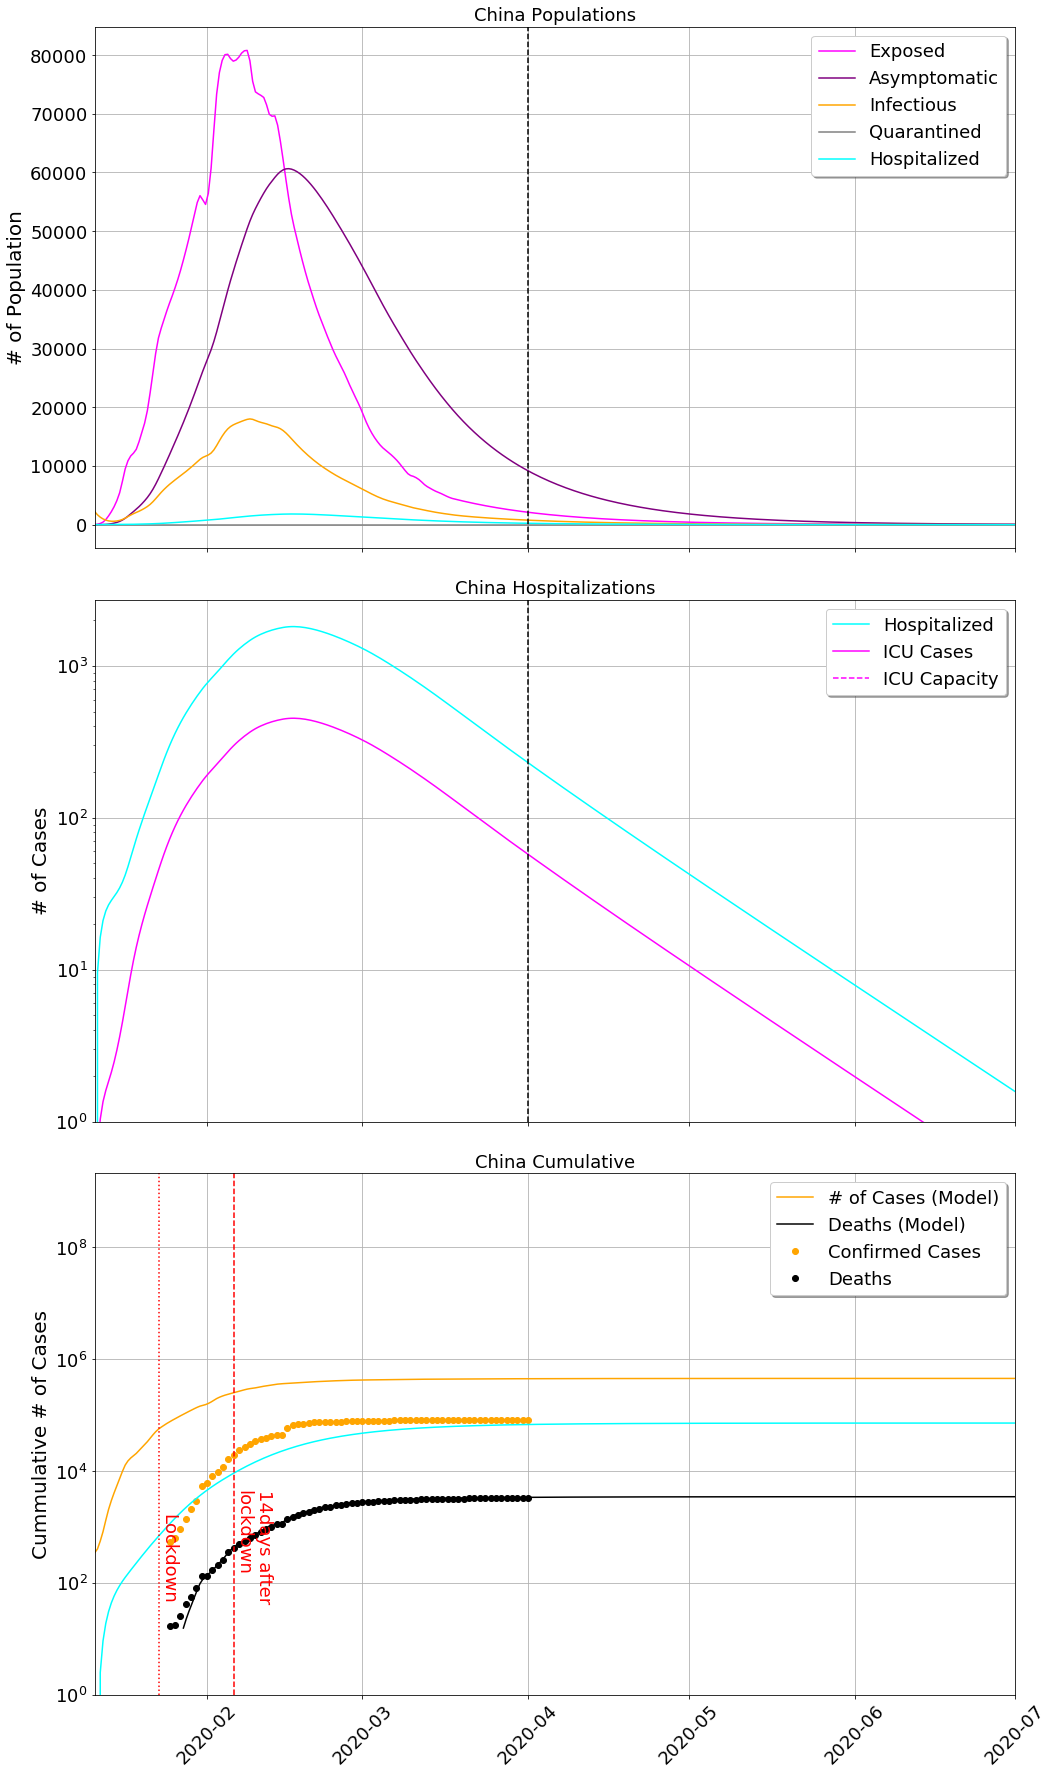

In [9]:
country = select_country('China')
plottage(country,RK3(country))

End of simulation at t = 280 days 

Korea, South
Percentage infected at peak of epidemics:  4 %
Number Symptomatic at peak of epidemics:  486007
Number Asymptomatic at peak of epidemics:  2070688
Number of hospitalized at peak of epidemics:  71916
Number needing ICU at peak of epidemics:  20592
Number of dead: 398822.0
Number of dead: 402018.0


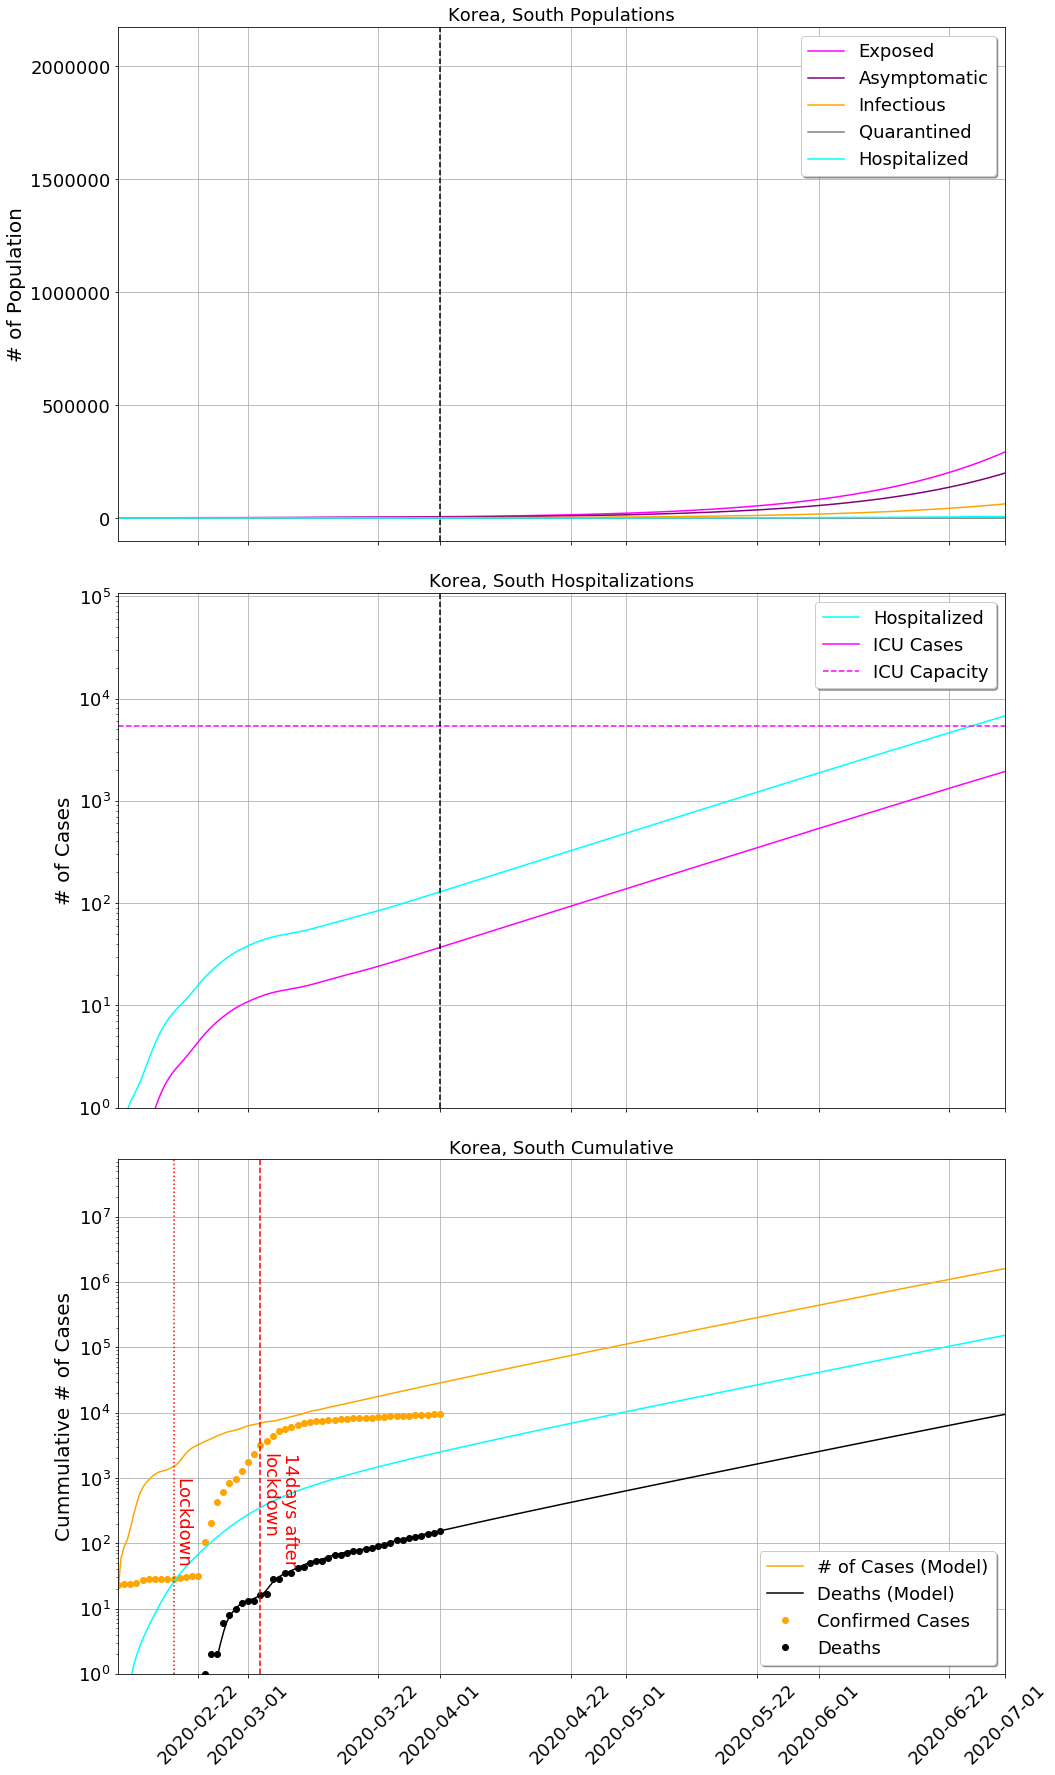

In [10]:
country = select_country('Korea, South')
plottage(country,RK3(country))


End of simulation at t = 280 days 

Italy
Percentage infected at peak of epidemics:  5 %
Number Symptomatic at peak of epidemics:  732274
Number Asymptomatic at peak of epidemics:  3068170
Number of hospitalized at peak of epidemics:  129466
Number needing ICU at peak of epidemics:  45649
Number of dead: 767676.0
Number of dead: 767747.0


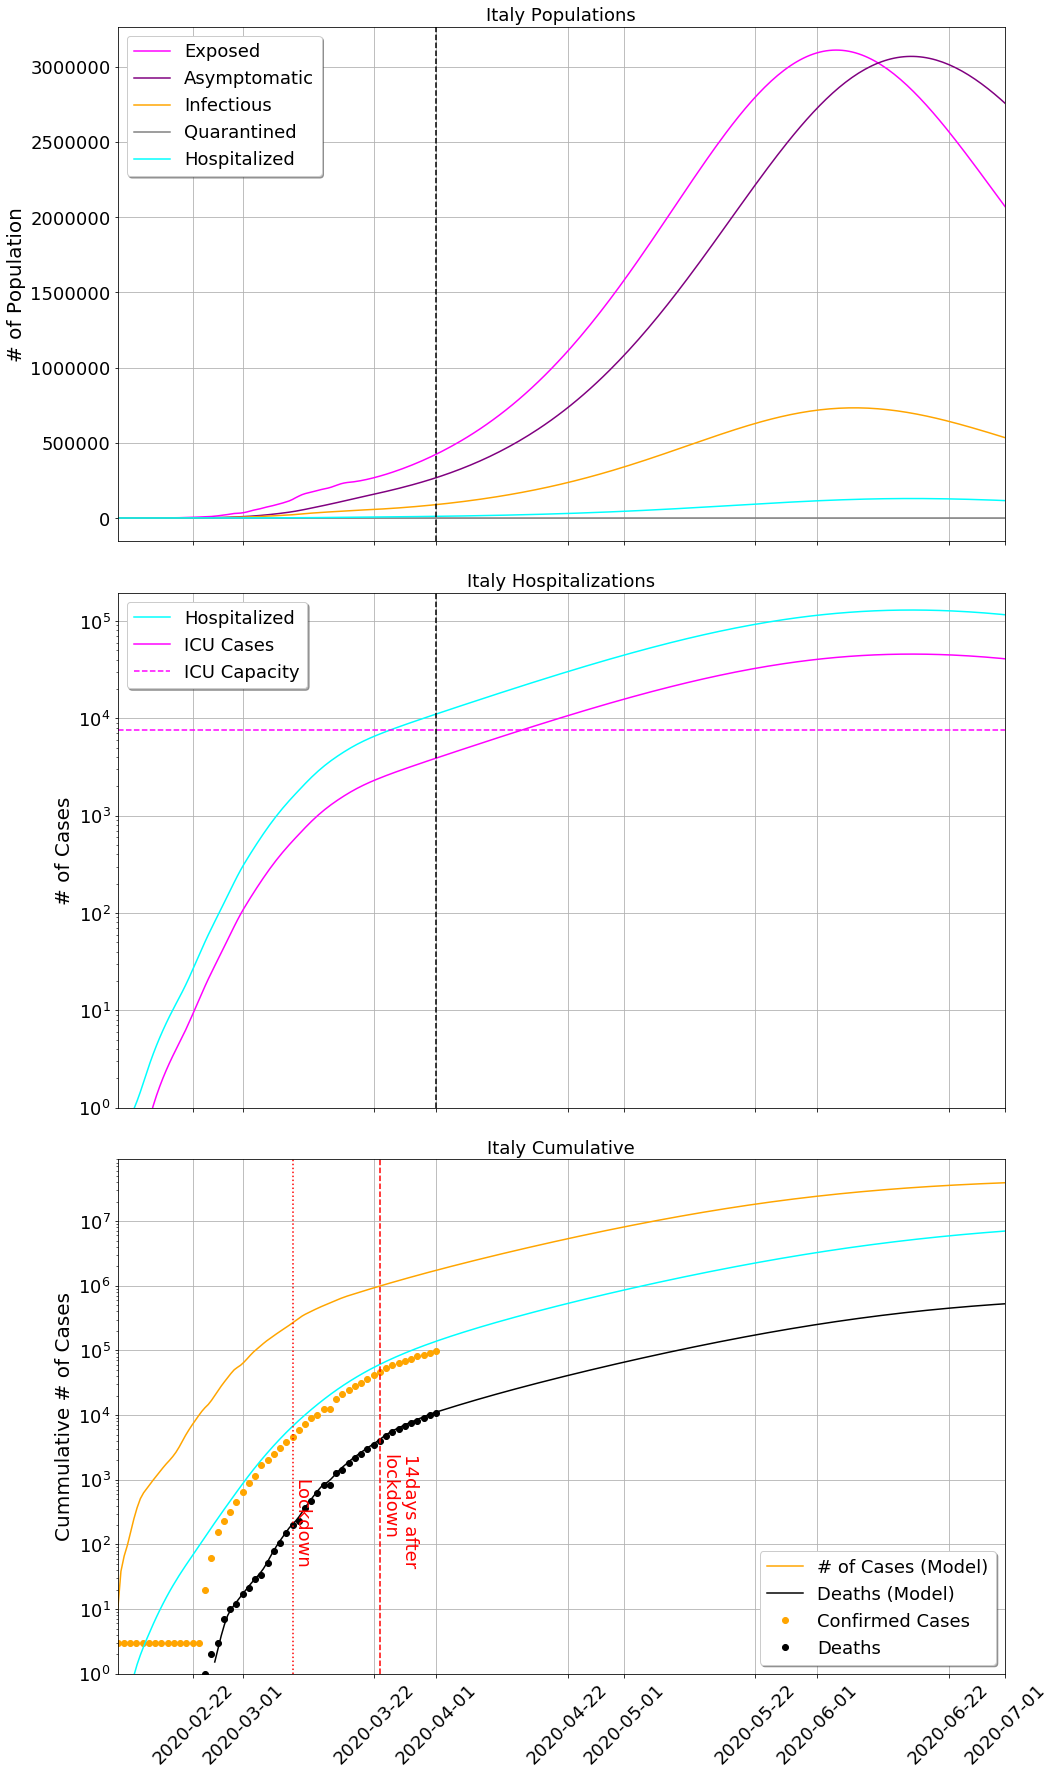

In [11]:
country = select_country('Italy')
plottage(country,RK3(country))

In [12]:
#country = select_country('Iran')
#plottage(country,RK3(country))

In [13]:
#country = select_country('Denmark')
#plottage(country,RK3(country))

In [14]:
##country = select_country('El Salvador')
##plottage(country,RK3(country))

In [15]:
#country = select_country('Ireland')
#plottage(country,RK3(country))

In [16]:
#country = select_country('Norway')
#plottage(country,RK3(country))

In [17]:
#country = select_country('Poland')
#plottage(country,RK3(country))

In [18]:
#country = select_country('United Kingdom')
#plottage(country,RK3(country))

In [19]:
#country = select_country('Switzerland')
#plottage(country,RK3(country))

In [20]:
#country = select_country('Spain')
#plottage(country,RK3(country))

End of simulation at t = 280 days 

Brazil
Percentage infected at peak of epidemics:  15 %
Number Symptomatic at peak of epidemics:  9360038
Number Asymptomatic at peak of epidemics:  30866134
Number of hospitalized at peak of epidemics:  783411
Number needing ICU at peak of epidemics:  197791
Number of dead: 1374581.0
Number of dead: 1374581.0


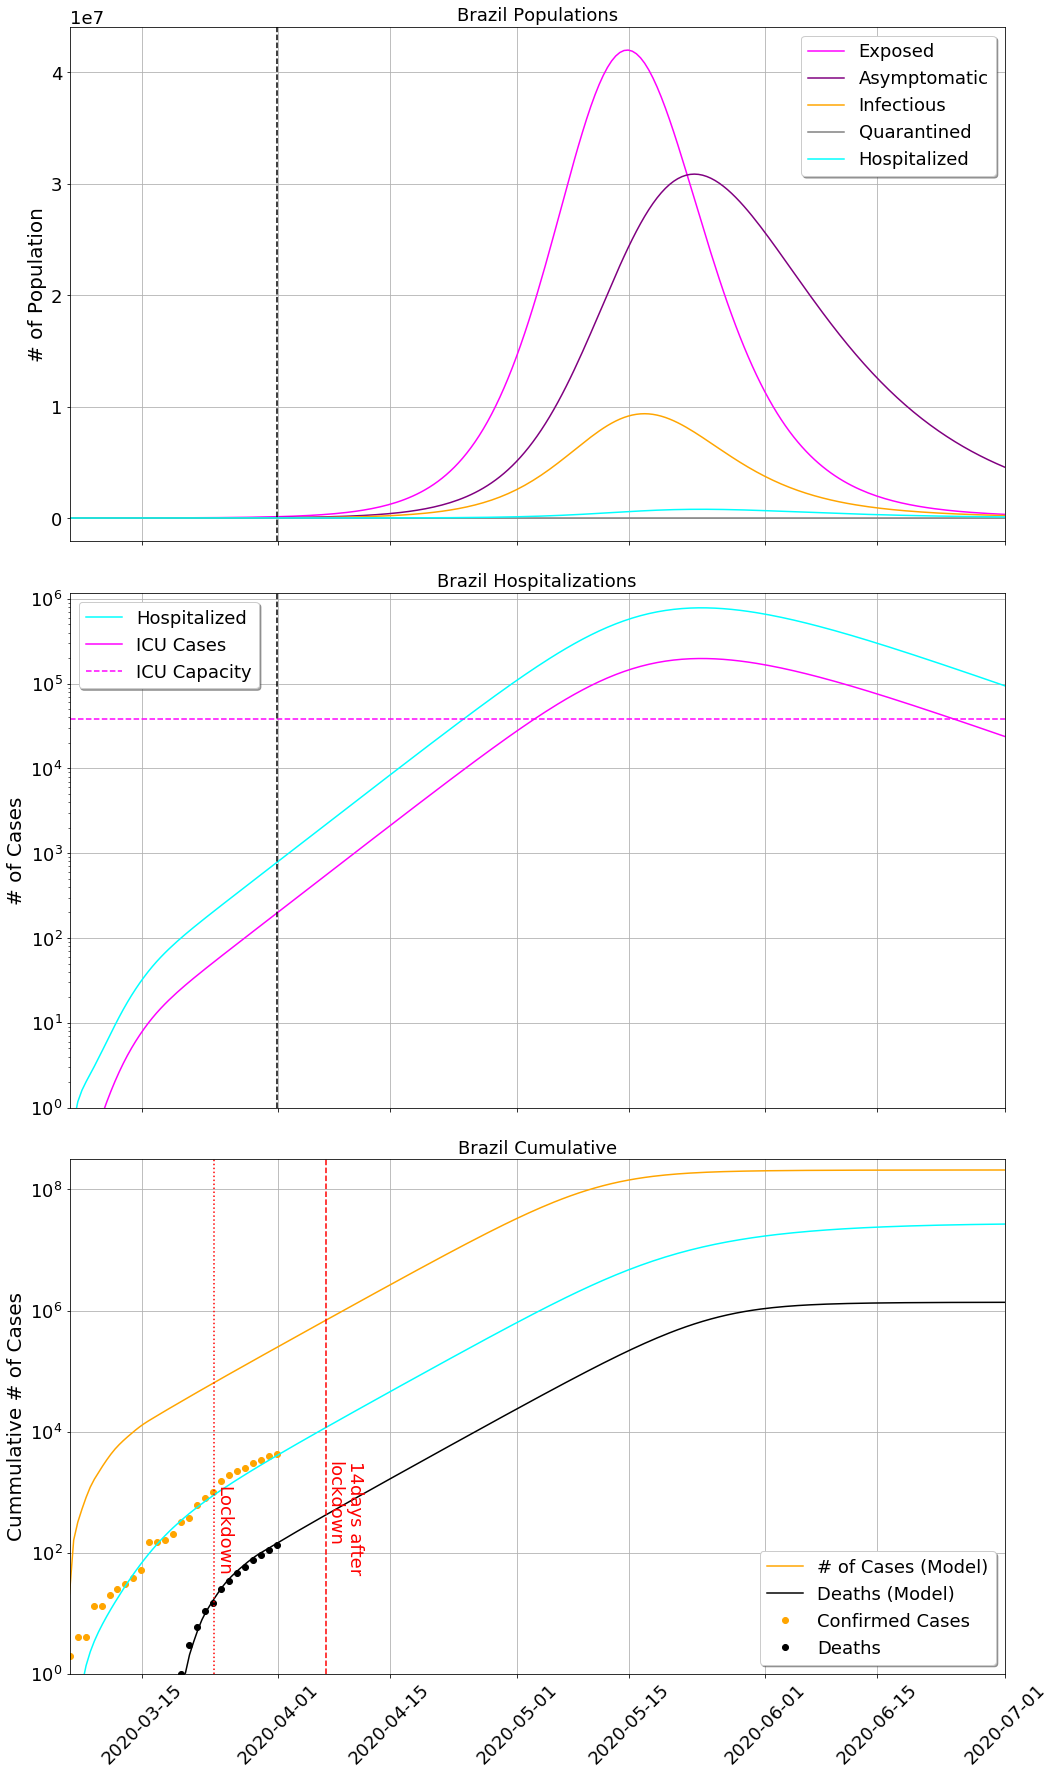

In [21]:
country = select_country('Brazil')
plottage(country,RK3(country))

End of simulation at t = 280 days 

US
Percentage infected at peak of epidemics:  16 %
Number Symptomatic at peak of epidemics:  16545277
Number Asymptomatic at peak of epidemics:  52138943
Number of hospitalized at peak of epidemics:  1792839
Number needing ICU at peak of epidemics:  555470
Number of dead: 3556736.0
Number of dead: 3556736.0


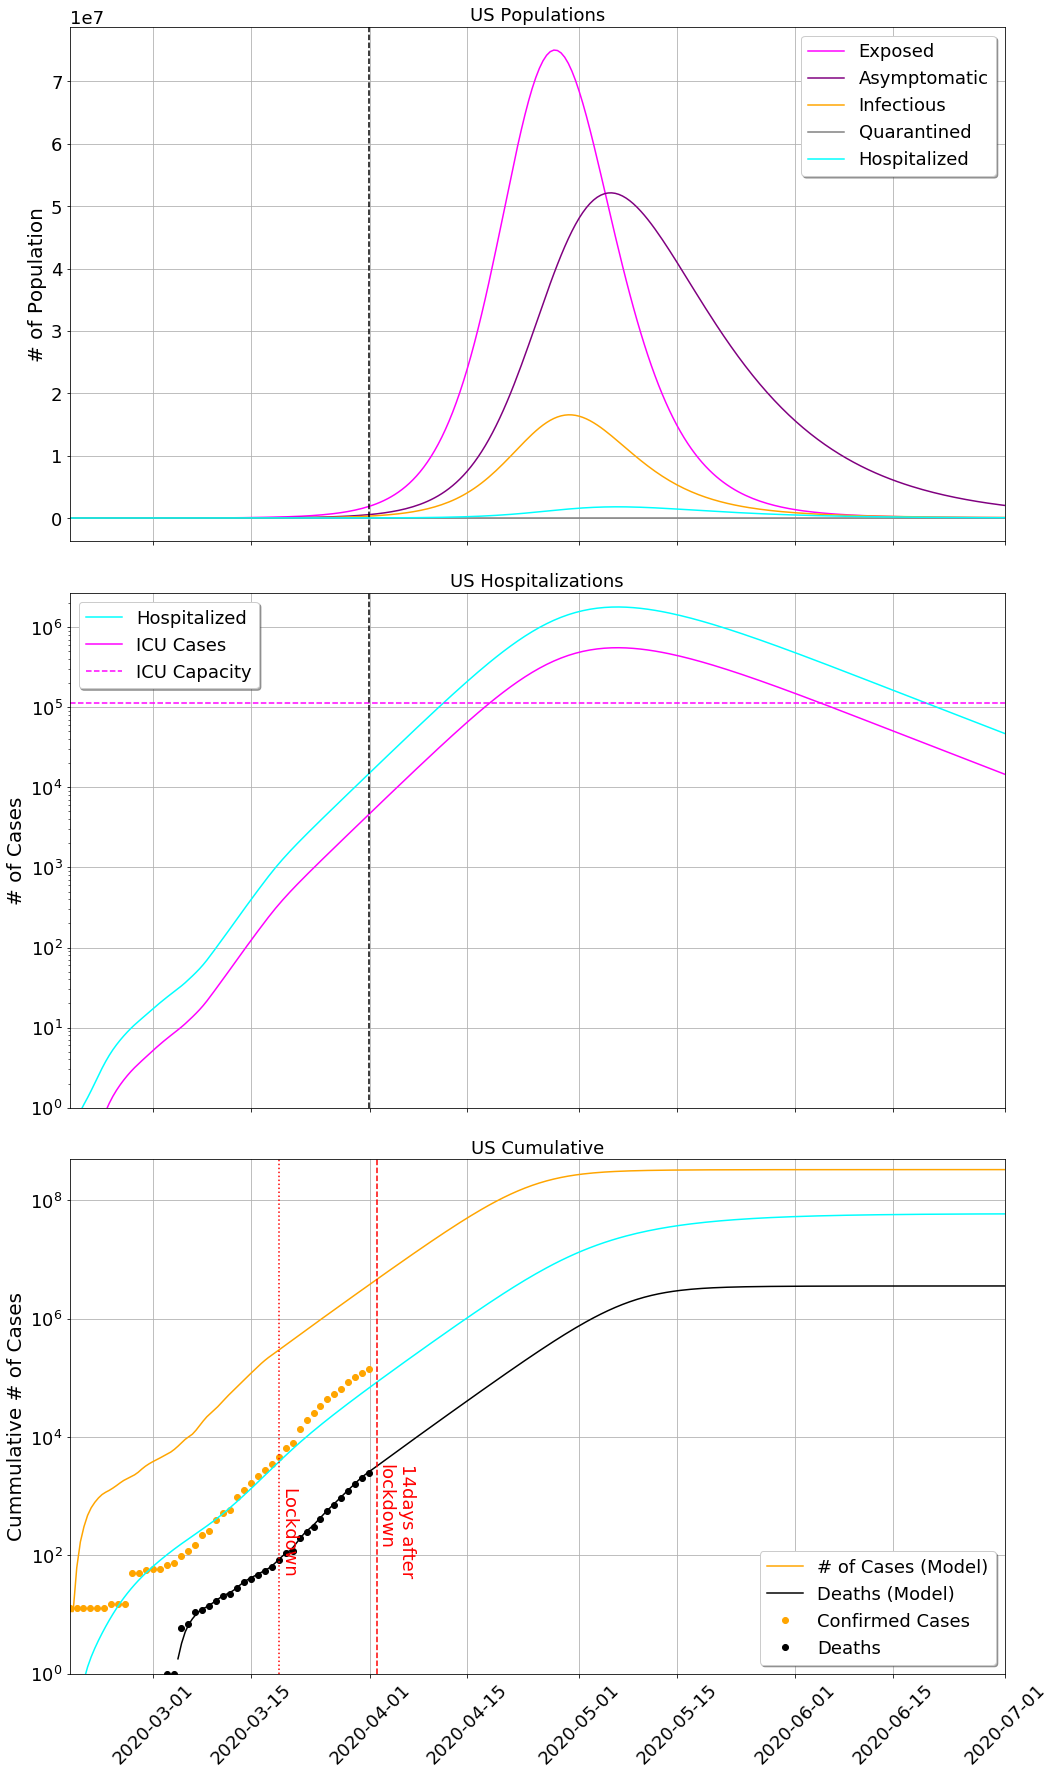

In [22]:
country = select_country('US')
plottage(country,RK3(country))

End of simulation at t = 280 days 

Germany
Percentage infected at peak of epidemics:  16 %
Number Symptomatic at peak of epidemics:  4188532
Number Asymptomatic at peak of epidemics:  13210876
Number of hospitalized at peak of epidemics:  564010
Number needing ICU at peak of epidemics:  195338
Number of dead: 1252087.0
Number of dead: 1252087.0


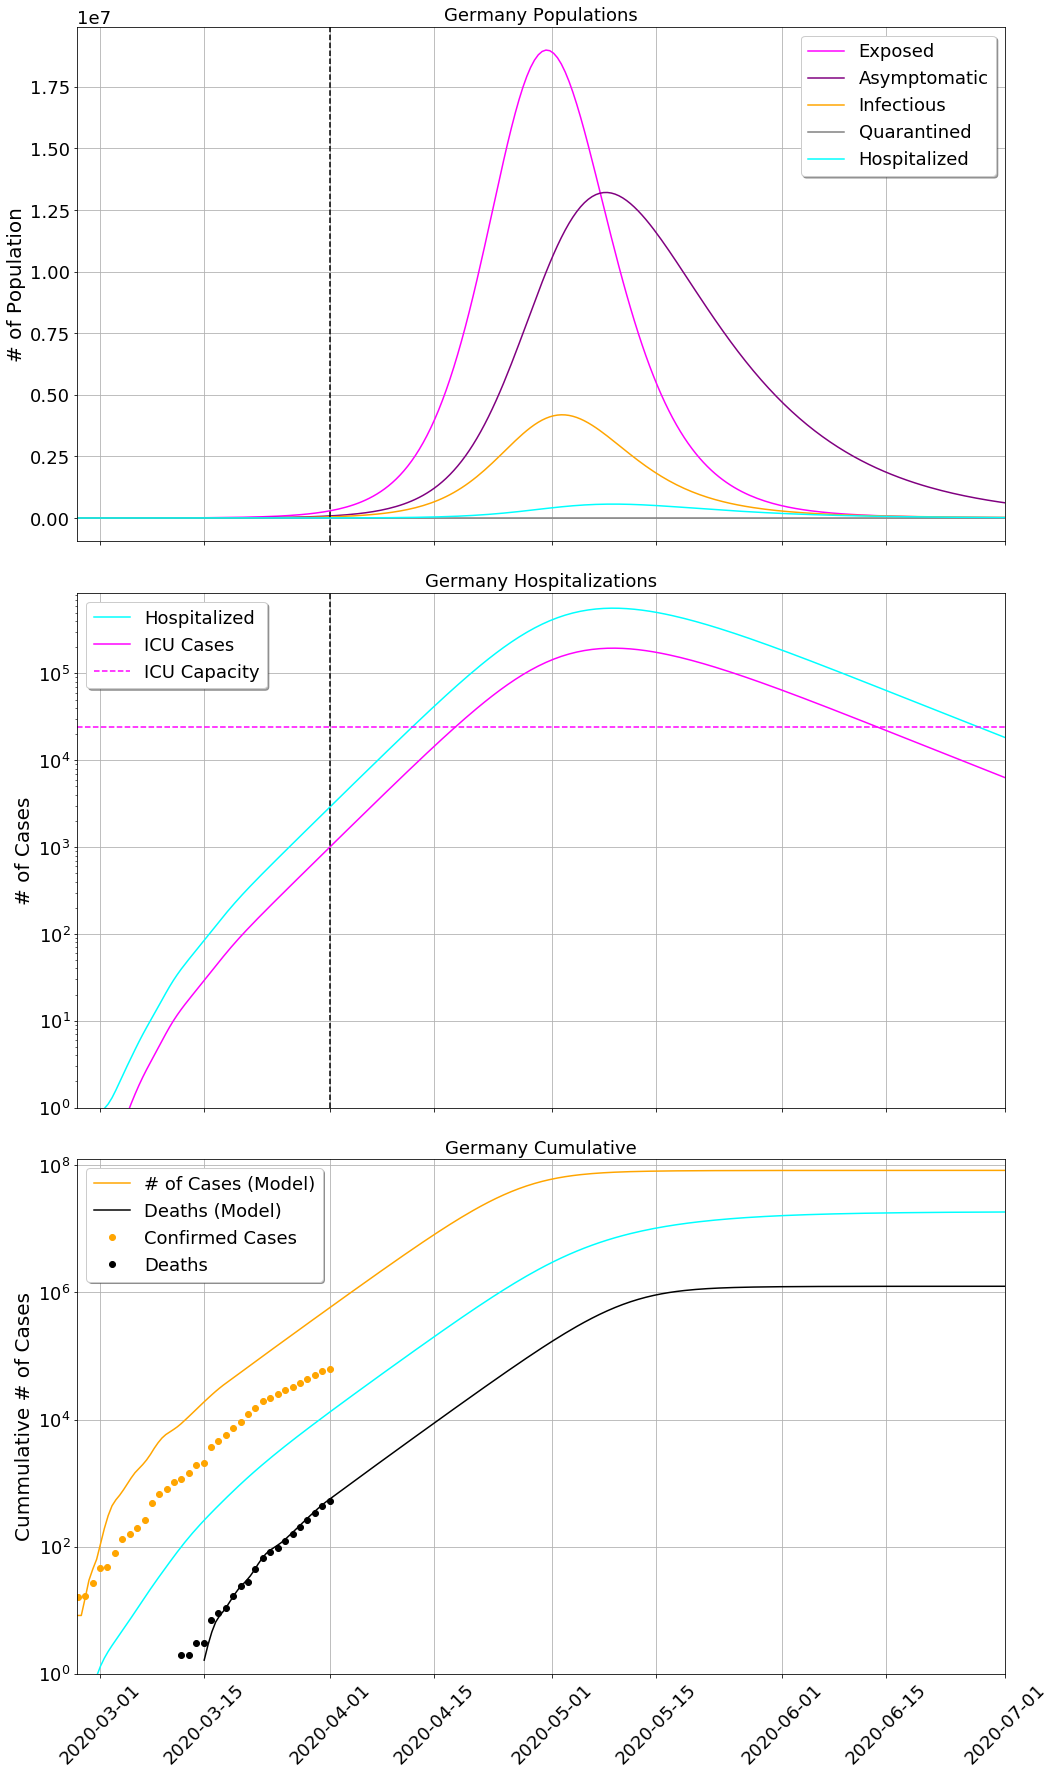

In [23]:
country = select_country('Germany')
plottage(country,RK3(country))

End of simulation at t = 280 days 

Tunisia
Percentage infected at peak of epidemics:  13 %
Number Symptomatic at peak of epidemics:  441227
Number Asymptomatic at peak of epidemics:  1530603
Number of hospitalized at peak of epidemics:  37365
Number needing ICU at peak of epidemics:  9180
Number of dead: 71110.0
Number of dead: 71110.0


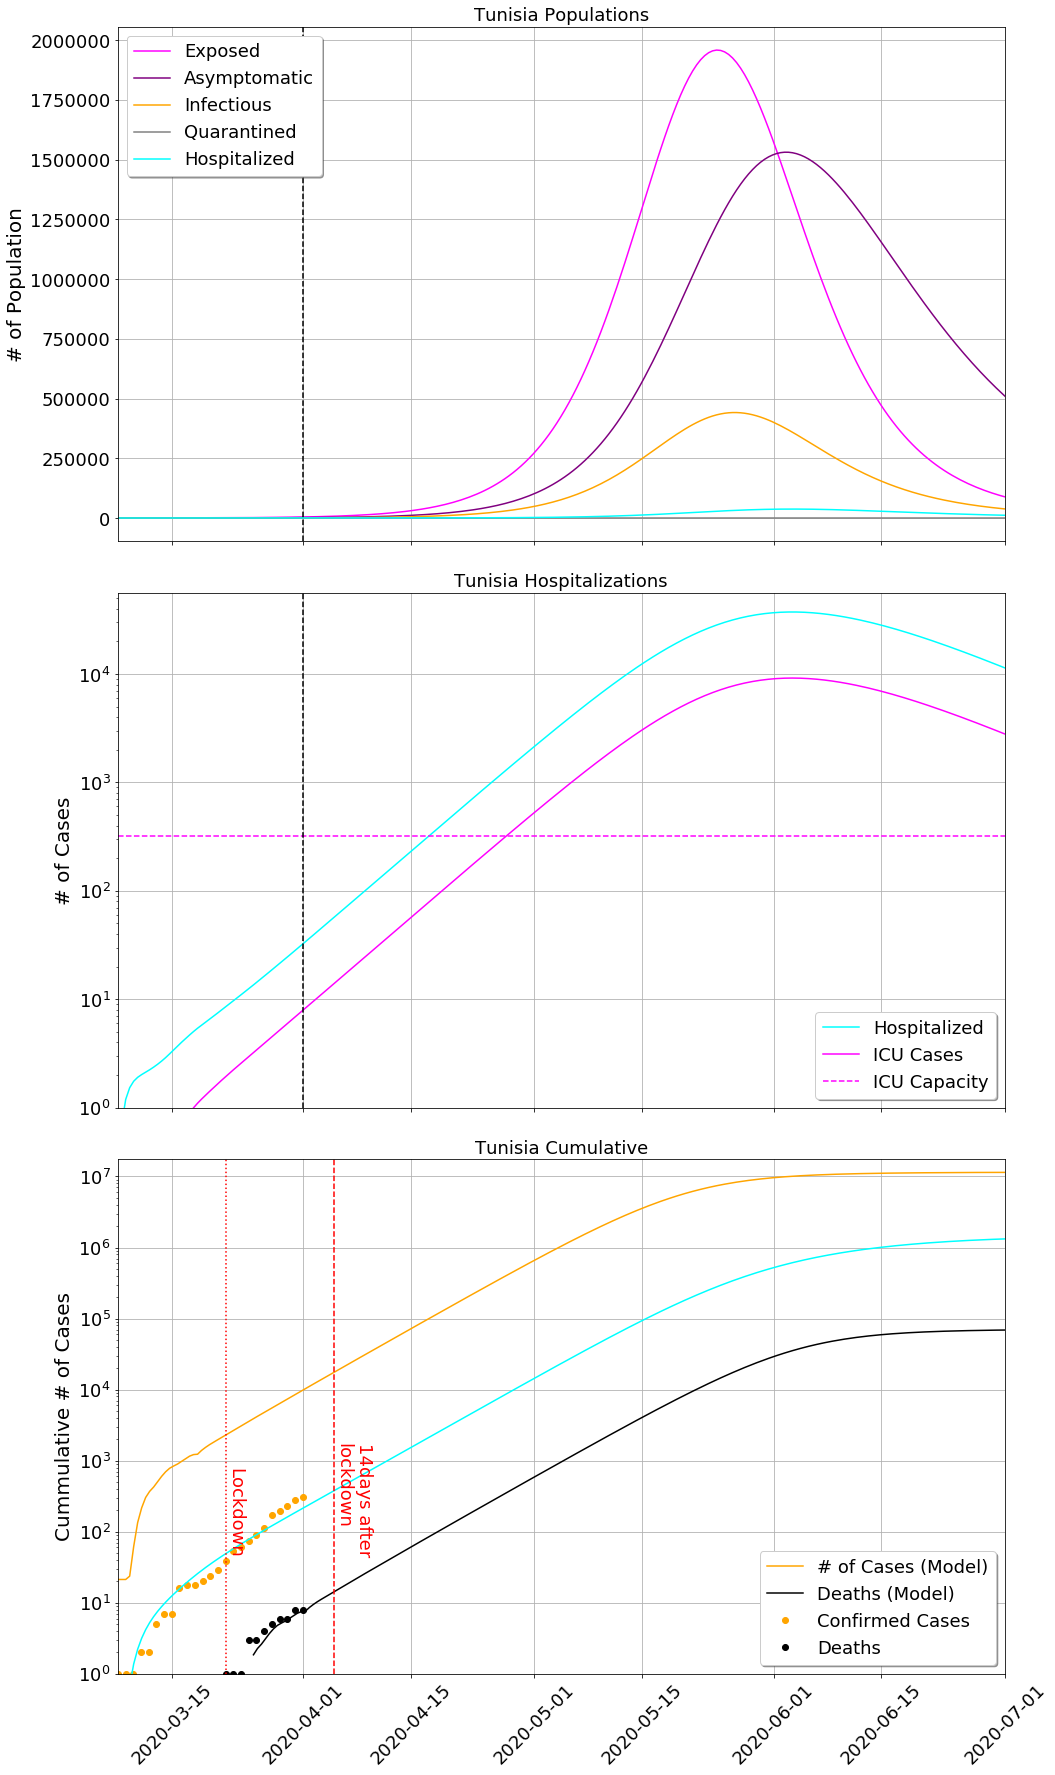

In [24]:
country = select_country('Tunisia')
plottage(country,RK3(country))

### Conclusions

This is the result of only a few hours of learning about modeling epidemiology; I do not claim the model is accurate. WHO is using a similar base model but with much more sophistication such as incubation period, transport between populations, birth and death rates, introduction of virus by the animal source, etc. For instance, $\beta$, the infection rate, depends on parameters of the population as well, like mobility. As such, it varies spatially. There's this 2D model here, applied to a city (Yerevan). 

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2

And here a 1D model solving for the populations of the animal vectors (presumably bats and including unidentified 'hosts') and people (BHRP model, for bats-hosts-reservoir-people). 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3


Still, the toy model in this notebook gives a good insight on the dynamics of the epidemics, and how social distancing works on stalling it and reducing the infection and death rate. 

# Stay home, everyone.




### References 

More on the model can be found here, and references therein. 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
    